🔍 Portfolio simulation for model: stackridge (test_preds_ensemble.csv)
📋 Loaded 11275 predictions. Columns: ['Race_ID', 'Horse', 'Pred_LGBM', 'Pred_RF', 'Pred_XGB', 'Pred_CAT', 'Pred_MLP', 'Pred_BlendAvg', 'Pred_StackRidge', 'Predicted_Probability', 'Market_Odds', 'Market_Prob', 'Edge_Score', 'True_Label', 'Flat_Return', 'Kelly_Frac', 'Kelly_Return', 'Frac_Kelly_Return']


C:\Users\dylan\AppData\Local\Temp\ipykernel_24200\2837967859.py:74: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\dylan\Documents\Projects\horse_model_project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


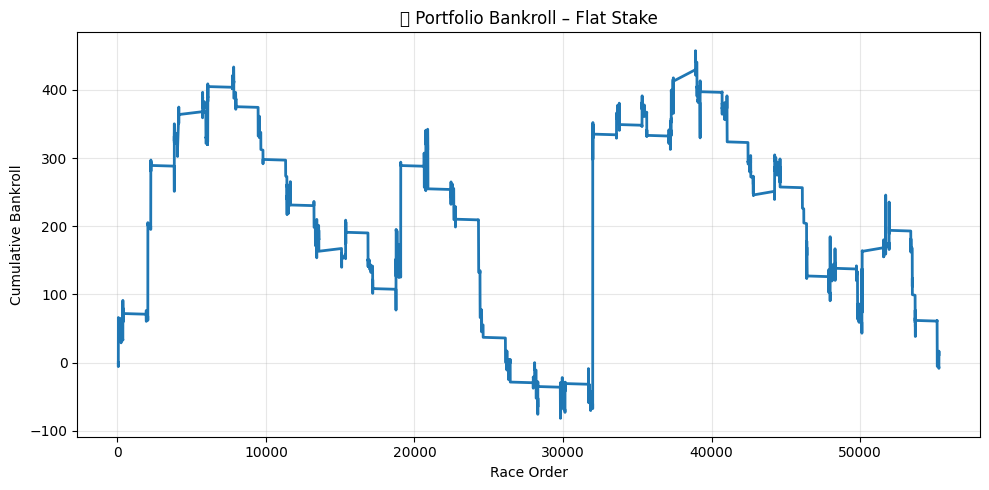

C:\Users\dylan\AppData\Local\Temp\ipykernel_24200\2837967859.py:84: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\dylan\Documents\Projects\horse_model_project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


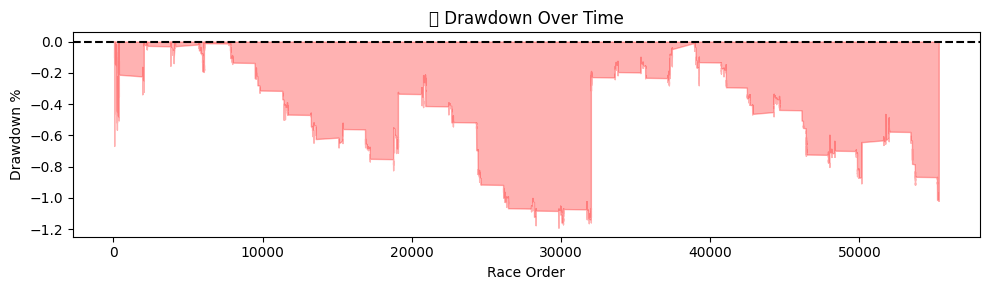

C:\Users\dylan\AppData\Local\Temp\ipykernel_24200\2837967859.py:74: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\dylan\Documents\Projects\horse_model_project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)



📊 Flat Stake Portfolio Stats
-----------------------------
Final Bankroll: 11.74
Max Drawdown: -inf%
Total Bets: 6981


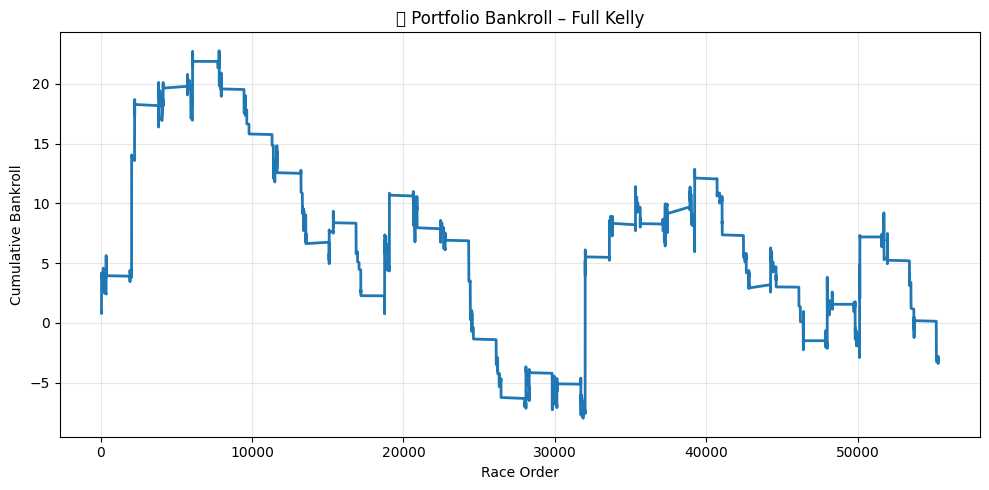

C:\Users\dylan\AppData\Local\Temp\ipykernel_24200\2837967859.py:84: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\dylan\Documents\Projects\horse_model_project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


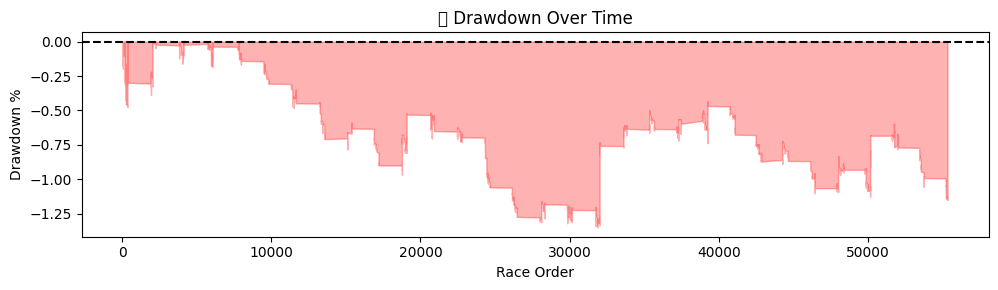

C:\Users\dylan\AppData\Local\Temp\ipykernel_24200\2837967859.py:74: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\dylan\Documents\Projects\horse_model_project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)



📊 Full Kelly Portfolio Stats
-----------------------------
Final Bankroll: -3.11
Max Drawdown: -135.03%
Total Bets: 6981


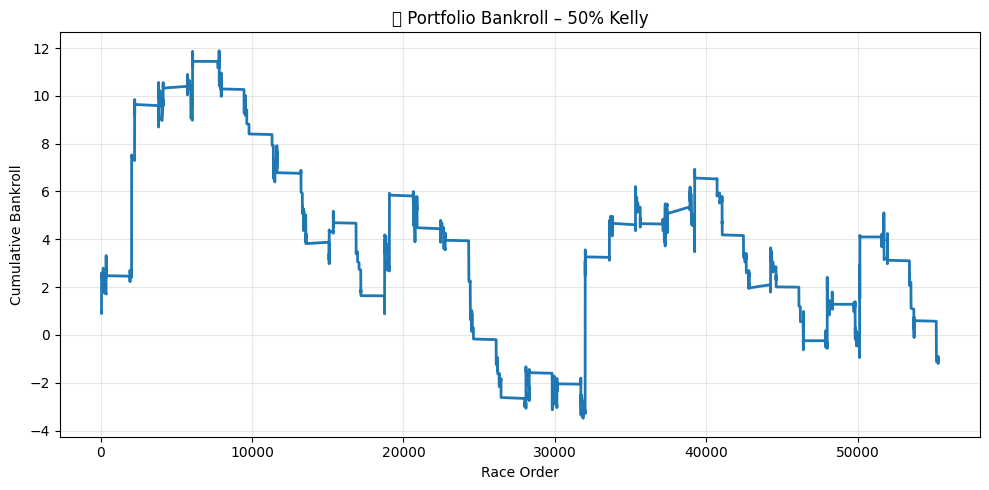

C:\Users\dylan\AppData\Local\Temp\ipykernel_24200\2837967859.py:84: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\dylan\Documents\Projects\horse_model_project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


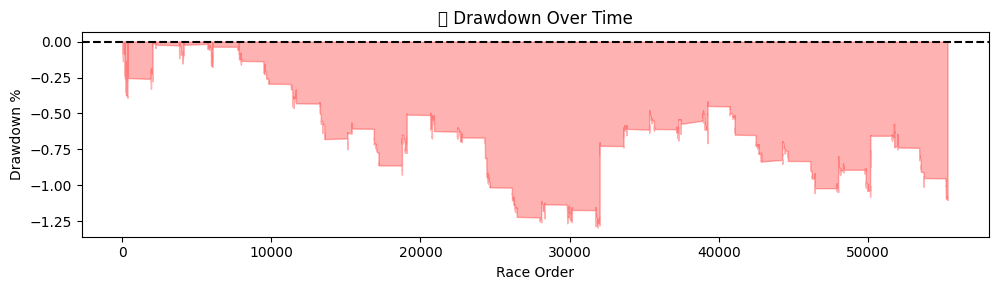


📊 50% Kelly Portfolio Stats
-----------------------------
Final Bankroll: -1.05
Max Drawdown: -129.35%
Total Bets: 6981

✅ Saved portfolio simulations to outputs/


In [1]:
# %%
# 💸 09_portfolio_simulator.ipynb – Bankroll & Drawdown Simulation
# -------------------------------------------------------------
# Track bankroll evolution and simulate drawdown over time using
# various staking strategies from the edge analysis output.

# %%
# === Imports and Setup ===
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from pathlib import Path

# Base path and imports
BASE = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
sys.path.append(str(BASE / "src"))

# --- CONFIG: Model Selection ---
CONFIG_PATH = BASE / "config.yaml"
with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)
print(f"🔍 Portfolio simulation for model: {config['default_model']} ({config['prediction_files'][config['default_model']]})")

# Load backtested betting results with returns (always up-to-date from 08)
EDGE_PATH = BASE / "outputs" / "test_predictions_with_edge.csv"
preds = pd.read_csv(EDGE_PATH)
print(f"📋 Loaded {len(preds)} predictions. Columns: {list(preds.columns)}")

# Ensure necessary columns exist and patch if needed
required_cols = {
    "Edge_Score", "Market_Odds", "Predicted_Probability", "True_Label",
    "Flat_Return", "Kelly_Return", "Frac_Kelly_Return"
}
missing = required_cols - set(preds.columns)
if missing:
    raise ValueError(f"❌ Required return columns missing from predictions: {missing}")

# === Optional Sorting Key (e.g. Race_Date or Race_ID) ===
if "Race_Date" in preds.columns:
    preds["Sort_Key"] = pd.to_datetime(preds["Race_Date"])
else:
    preds["Sort_Key"] = preds["Race_ID"]

# %%
# === Bankroll Simulator Function ===
def simulate_bankroll(df, stake_col: str, label: str = None):
    """
    Simulates bankroll evolution given a returns column.
    Returns dataframe with bankroll trajectory and stats.
    """
    df_sorted = df.sort_values("Sort_Key").copy()
    df_sorted["Bankroll"] = 1.0  # Start with 1 unit

    bankroll = [1.0]
    for ret in df_sorted[stake_col]:
        bankroll.append(bankroll[-1] + ret)

    df_sorted["Bankroll_Progression"] = bankroll[1:]

    # Compute drawdown
    cum_max = df_sorted["Bankroll_Progression"].cummax()
    df_sorted["Drawdown"] = (df_sorted["Bankroll_Progression"] - cum_max) / cum_max
    max_drawdown = df_sorted["Drawdown"].min()

    # Plot bankroll
    plt.figure(figsize=(10, 5))
    plt.plot(df_sorted["Sort_Key"], df_sorted["Bankroll_Progression"], label="Bankroll", lw=2)
    plt.title(f"📈 Portfolio Bankroll – {label or stake_col}")
    plt.xlabel("Race Order")
    plt.ylabel("Cumulative Bankroll")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot drawdown
    plt.figure(figsize=(10, 3))
    plt.fill_between(df_sorted["Sort_Key"], df_sorted["Drawdown"], color='red', alpha=0.3)
    plt.axhline(0, color='black', linestyle='--')
    plt.title("📉 Drawdown Over Time")
    plt.ylabel("Drawdown %")
    plt.xlabel("Race Order")
    plt.tight_layout()
    plt.show()

    # Print key stats
    print(f"\n📊 {label or stake_col} Portfolio Stats")
    print("-----------------------------")
    print(f"Final Bankroll: {df_sorted['Bankroll_Progression'].iloc[-1]:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")
    print(f"Total Bets: {len(df_sorted)}")

    return df_sorted

# %%
# === Simulate Portfolios ===
# Only bet when model has positive edge
bets_df = preds[preds["Edge_Score"] > 0].copy()
flat_df = simulate_bankroll(bets_df, stake_col="Flat_Return", label="Flat Stake")
kelly_df = simulate_bankroll(bets_df, stake_col="Kelly_Return", label="Full Kelly")
frac_df  = simulate_bankroll(bets_df, stake_col="Frac_Kelly_Return", label="50% Kelly")

# %%
# === Save to Disk for Analysis ===
flat_df.to_csv(BASE / "outputs" / "portfolio_flat.csv", index=False)
kelly_df.to_csv(BASE / "outputs" / "portfolio_kelly.csv", index=False)
frac_df.to_csv(BASE / "outputs" / "portfolio_frac_kelly.csv", index=False)
print("\n✅ Saved portfolio simulations to outputs/")


